<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_12_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D1%81%D1%82%D1%80%D0%BE%D0%B9%D0%BA%D0%B8_%D0%BF%D0%BE%D0%B4%D0%B3%D0%BE%D1%82%D0%BE%D0%B2%D0%BA%D0%B0_%D0%B1%D0%B0%D0%B7%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Теоретический материал:* https://youtu.be/E8RsblFqFZs?t=284

# Подключение бибилиотек

*Разбор данного раздела:* https://youtu.be/E8RsblFqFZs?t=698

In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями

In [ ]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Mounted at /content/drive


# Сегментация стройки

## Загрузка картинок

*Разбор данного раздела:* https://youtu.be/E8RsblFqFZs?t=752


In [ ]:
# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки 
img_height = 240 # Высота уменьшенной картинки 
num_classes = 7 # Задаем количество классов на изображении
directory = '/content/drive/My Drive/Занятие_12_Сегментация/Сегментация' # Указываем путь к обучающей выборке с оригинальными изображения
train_directory = '/Тренировочная_стройка' # Название папки с файлами обучающей выборки
val_directory = '/Проверочная_стройка' # Название папки с файлами проверочной выборки

### Оригинальные изображения

*Разбор данного раздела:* https://youtu.be/E8RsblFqFZs?t=812

In [ ]:
train_images = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки
test_images = [] # Создаем пустой список для хранений оригинльных изображений тестовой выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути     
    train_images.append(image.load_img(os.path.join(directory + train_directory+'/Исходники',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_images)) # Отображаем количество элементов в обучающей выборке

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + val_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути                  
    val_images.append(image.load_img(os.path.join(directory + val_directory+'/Исходники',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_images)) # Отображаем количество элементов в проверочной выборке

Обучающая выборка загружена. Время загрузки: 658.91c
Количество изображений:  900
Проверочная выборка загружена. Время загрузки: 36.44c
Количество изображений:  50


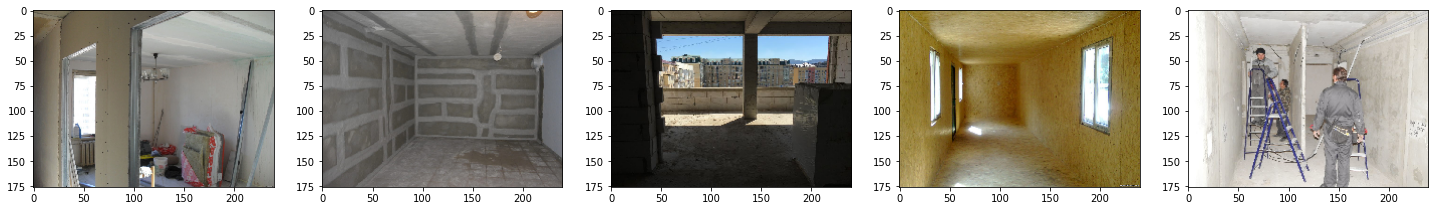

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(train_images) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

### Сегментированные изображения

*Разбор данного раздела:* https://youtu.be/E8RsblFqFZs?t=1097

In [ ]:
train_segments = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинльных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): # Проходим по всем файлам в каталоге по указанному пути     
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_segments)) # Отображаем количество элементов в обучающем наборе сегментированных изображений

cur_time = time.time() # Засекаем текущее время
# Проходим по всем файлам в каталоге по указанному пути 
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):
    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_segments)) # Отображаем количество элементов в проверочном наборе сегментированных изображений

Обучающая выборка загржуена. Время загрузки: 419.25c
Количество изображений:  900
Проверочная выборка загржуена. Время загрузки: 24.72c
Количество изображений:  50


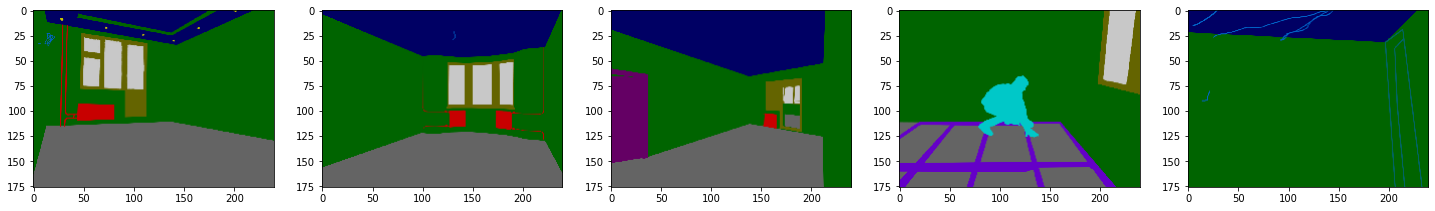

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(train_segments) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

## Создание выборки

*Разбор данного раздела:* https://youtu.be/E8RsblFqFZs?t=1308


In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс (7 классов)
def color2index(color):
  index=-1
  if   (149>=color[0]>51)   and(149>=color[1]>=51)  and(149>=color[2]>=51) : index=0 # пол
  elif (49>=color[0]>=0)    and(49>=color[1]>=0)    and(149>=color[2]>=51) : index=1 # потолок
  elif (49>=color[0]>=0)    and(149>=color[1]>=51)  and(49>=color[2]>=0) : index=2 # стена
  elif (149>=color[0]>=51)  and(49>=color[1]>=0)    and(49>=color[2]>=0) : index=4 # колонна
  elif (49>=color[0]>=0)    and(149>=color[1]>=51)  and(149>=color[2]>=51) : index=3 # проем
  elif (149>=color[0]>=51)  and(49>=color[1]>=0)    and(149>=color[2]>=51) : index=3 # дверь
  elif (149>=color[0]>=51)  and(149>=color[1]>=51)  and(49>=color[2]>=0) : index=3 # окно
  elif (249>=color[0]>=151) and(249>=color[1]>=151) and(249>=color[2]>=151) : index=4 # внешний мир
  elif (49>=color[0]>=0)    and(49>=color[1]>=51)   and(249>=color[2]>=151) : index=4 # лестница
  elif (49>=color[0]>=0)    and(249>=color[1]>=151) and(49>=color[2]>=0) : index=4 # перила
  elif (249>=color[0]>=151) and(49>=color[1]>=0)    and(49>=color[2]>=0) : index=4 # батарея
  elif (49>=color[0]>=0)    and(249>=color[1]>=151) and(249>=color[2]>=151) : index=5 # люди
  elif (249>=color[0]>=151) and(49>=color[1]>=0)    and(249>=color[2]>=151) : index=4 # инвентарь
  elif (249>=color[0]>=151) and(249>=color[1]>=151) and(49>=color[2]>=0) : index=4 # источники света
  elif (49>=color[0]>=0)    and(149>=color[1]>=51)  and(249>=color[2]>=151) : index=4 # провода
  elif (149>=color[0]>=51)  and(49>=color[1]>=0)    and(249>=color[2]>=151) : index=4 # балка
  else: index=6
  return index  

In [ ]:
# Функция преобразования индекса в цвет пикселя
def index2color(index2):
  index = np.argmax(index2) # Получаем индекс максимального элемента
  color=[]
  if   index == 0: color = [100, 100, 100]  # пол
  elif index == 1: color = [0, 0, 100]  # потолок
  elif index == 2: color = [0, 100, 0]  # стена
  elif index == 3: color = [100, 0, 0]  # проем, дверь, окно
  elif index == 4: color = [0, 100, 100]  # колонна, лестница, внешний мир, перила, батарея, инвентарь, источники света, провода, балка
  elif index == 5: color = [100, 0, 100]  # люди
  elif index == 6: color = [0, 0, 0]  # остальное
  return color # Возвращаем цвет пикслея

In [ ]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем канала изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходныму размеру
  return yt # Возвращаем сформированный массив

In [ ]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегметации
  for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
    y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

In [ ]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in train_images: # Проходим по всем изображениям из train_images
  x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy

xVal = [] # Создаем пустой список под проверочную выборку
for img in val_images: # Проходим по всем изображениям из val_images
  x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xVal.append(x) # Добавляем очередной элемент в xTrain
xVal = np.array(xVal) # Переводим в numpy

print(xTrain.shape) # Размерность обучающей выборки
print(xVal.shape) # Размерность проверочной выборки

(900, 176, 240, 3)
(50, 176, 240, 3)


In [ ]:
os.chdir('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка')
np.save('xTrain', xTrain)
np.save('xVal', xVal)

In [ ]:
cur_time = time.time() # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

100
200
300
400
500
600
700
800
900
Время обработки:  1210.13 c


In [ ]:
cur_time = time.time() # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes) # Создаем yVal
print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

print(yTrain.shape) # Размерность обучающей выборки
print(yVal.shape) # Размерность проверочной выборки

Время обработки:  63.19 c
(900, 176, 240, 7)
(50, 176, 240, 7)


In [ ]:
os.chdir('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка')
np.save('yTrain', yTrain)
np.save('yVal', yVal)

## Модели

*Разбор данного раздела:* https://youtu.be/E8RsblFqFZs?t=2056

In [ ]:
os.chdir('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка')
xTrain, yTrain = np.load('xTrain.npy'), np.load('yTrain.npy')
xVal, yVal= np.load('xVal.npy'), np.load('yVal.npy')
print('xTrain\t', xTrain.shape, '\nyTrain\t', yTrain.shape,
      '\nxVal\t', xVal.shape, '\nyVal\t', yVal.shape)

и тд... 